# FFILL

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from   sklearn.decomposition import PCA
from   tqdm import tqdm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [12]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from CollectData import DataManager

In [79]:
def _get_pca(df: pd.DataFrame) -> pd.DataFrame: 

    df_wider = (df.drop(
        columns = ["Description"]).
        pivot(index = "date", columns = "security", values = "value").
        dropna())
    
    data = (pd.DataFrame(
        data    = PCA(n_components = 3).fit_transform(df_wider),
        index   = df_wider.index,
        columns = ["PC{}".format(i + 1) for i in range(3)]).
        reset_index().
        melt(id_vars = "date"))

    return data

def _lag_signal(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(lag_signal = lambda x: x.spread.shift()))

    return df_out

def get_baseline_sharpe() -> pd.DataFrame: 

    df_inflation, df_breakeven = DataManager().get_inflation_swap(), DataManager().get_breakeven()
    
    df_sharpe = (pd.concat([
        _get_pca(df_inflation).assign(curve = "inflation"),
        _get_pca(df_breakeven).assign(curve = "breakeven")]).
        pivot(index = ["date", "variable"], columns = "curve", values = "value").
        dropna().
        reset_index().
        assign(spread = lambda x: x.breakeven - x.inflation).
        groupby("variable").
        apply(_lag_signal, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]).
        dropna()
        [["date", "variable", "lag_signal"]].
        merge(right = DataManager().get_tsy_fut(), how = "inner", on = ["date"]).
        drop(columns = ["PX_LAST", "PX_dur", "PX_cnvx", "PX_rtn", "PX_diff"]).
        assign(
            security   = lambda x: x.security.str.split(" ").str[0],
            signal_rtn = lambda x: np.sign(x.lag_signal) * x.PX_bps)
        [["variable", "security", "signal_rtn"]].
        groupby(["variable", "security"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn", 
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        reset_index())

    return df_sharpe

df_baseline = get_baseline_sharpe()

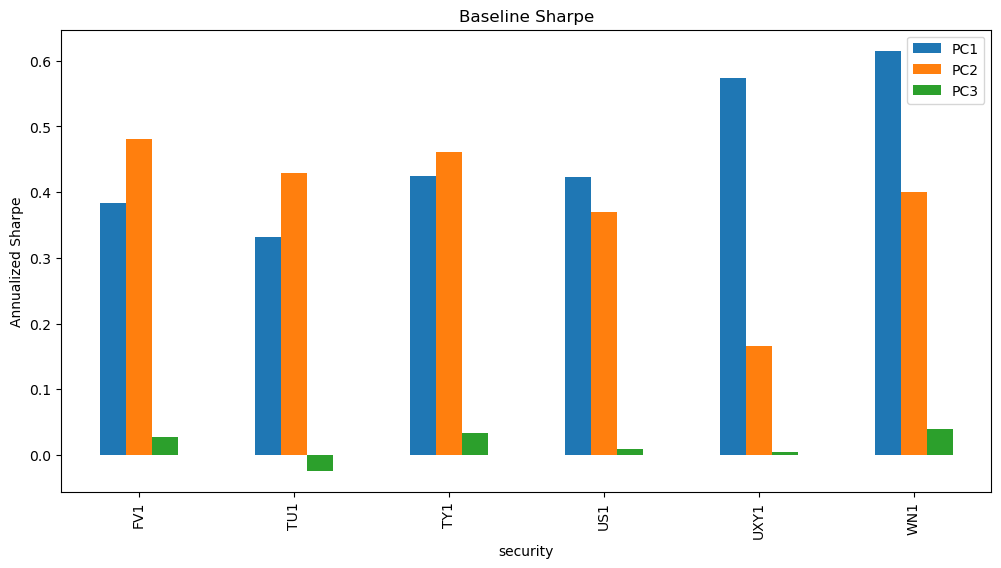

In [19]:
def plot_baseline_sharpe(df_baseline: pd.DataFrame) -> plt.Figure: 

    (df_baseline.rename(
        columns = {"variable": ""}).
        pivot(index = "security", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            title   = "Baseline Sharpe",
            figsize = (12,6)))

plot_baseline_sharpe(df_baseline)

## FFILL

In [117]:
def _ffill_pca(df: pd.DataFrame) -> pd.DataFrame: 

    df_wider = (df.drop(
        columns = ["Description"]).
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        pivot(index = "date", columns = "security", values = "value").
        ffill().
        dropna())

    df_out = (pd.DataFrame(
        data    = PCA(n_components = 3).fit_transform(df_wider),
        index   = df_wider.index,
        columns = ["PC{}".format(i + 1) for i in range(3)]).
        reset_index().
        melt(id_vars = "date"))

    return df_out

def get_ffill_sharpe() -> pd.DataFrame: 

    df_inflation, df_breakeven = _ffill_pca(DataManager().get_inflation_swap()), _ffill_pca(DataManager().get_breakeven())
    
    df_signal = (df_inflation.rename(columns = {
        "value": "inflation"}).
        merge(right = df_breakeven, how = "inner", on = ["date", "variable"]).
        rename(columns = {"value": "breakeven"}).
        assign(spread = lambda x: x.breakeven - x.inflation).
        groupby("variable").
        apply(_lag_signal, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]).
        dropna())
    
    df_sharpe = (df_signal[
        ["date", "variable", "lag_signal"]].
        merge(right = DataManager().get_tsy_fut(), how = "inner", on = ["date"]).
        assign(
            signal_bps = lambda x: np.sign(x.lag_signal) * x.PX_bps,
            security   = lambda x: x.security.str.split(" ").str[0])
        [["variable", "security", "signal_bps"]].
        groupby(["security", "variable"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())

    return df_sharpe

df_ffill_sharpe = get_ffill_sharpe()

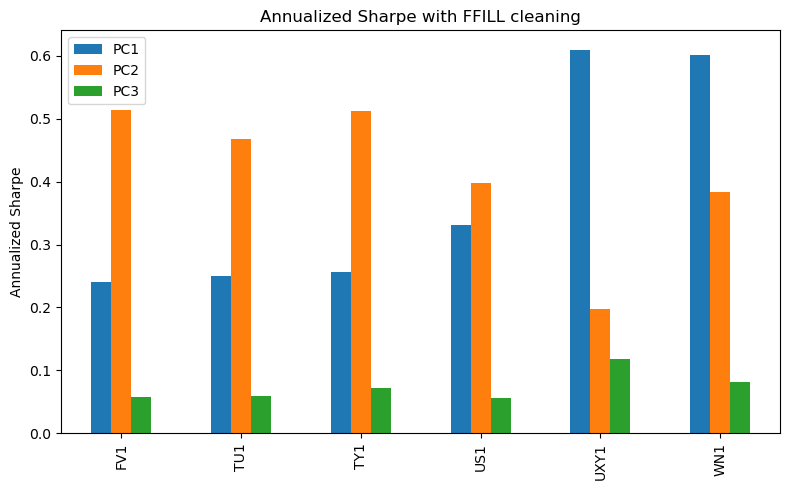

In [146]:
def plot_ffill_sharpe(df_ffill_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_ffill_sharpe[
        ["security", "variable", "sharpe"]].
        rename(columns = {"variable": ""}).
        pivot(index = "security", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe with FFILL cleaning",
            figsize = (8,5)))

    plt.tight_layout()

plot_ffill_sharpe(df_ffill_sharpe)

Now compare the two 

In [167]:
def combine_sharpe(df_ffill_sharpe: pd.DataFrame, df_baseline: pd.DataFrame) -> pd.DataFrame:

    df_combined = (df_ffill_sharpe.rename(
        columns = {"sharpe": "ffill"})
        [["security", "variable", "ffill"]].
        merge(right = df_baseline, how = "inner", on = ["security", "variable"]).
        rename(columns = {"sharpe": "dropna"}))

    return df_combined

df_sharpe_combined = combine_sharpe(df_ffill_sharpe, df_baseline)

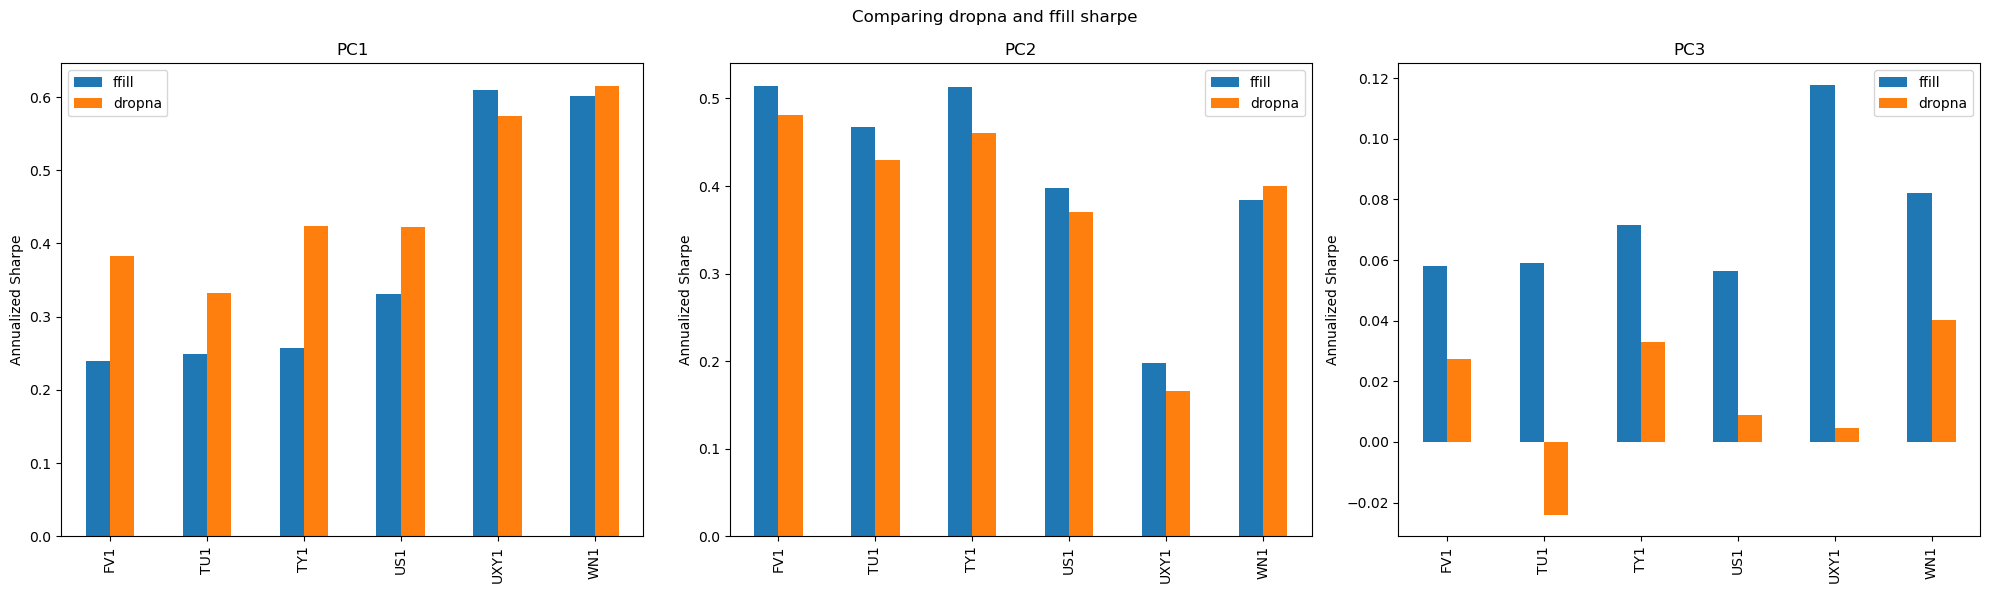

In [193]:
def plot_sharpe_comparison(df_sharpe_combined: pd.DataFrame) -> plt.Figure: 

    variables = df_sharpe_combined.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_sharpe_combined.query(
            "variable == @variable").
            set_index("security").
            drop(columns = ["variable"]).
            plot(
                kind   = "bar",
                ax     = ax,
                title  = variable,
                ylabel = "Annualized Sharpe",
                xlabel = ""))
    
    fig.suptitle("Comparing dropna and ffill sharpe")
    plt.tight_layout()

plot_sharpe_comparison(df_sharpe_combined)